In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import datetime as dt

In [3]:
#print("/Accident data/US_Accidents_Dec19.csv")
accidents_source=pd.read_csv("Accident data/US_Accidents_Dec19.csv")

In [4]:
accidents_source.size

145742415

In [4]:
accidents_source.shape

(2974335, 49)

In [5]:
accidents_source.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [6]:
accidents_source.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [7]:
accidents_source.dtypes

ID                        object
Source                    object
TMC                      float64
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitat

In [8]:
#accidents_source[["Start Date","Start Time"]]=accidents_source["Start_Time"].str.split(expand=True)

In [9]:
#accidents_source[["End Date","End Time"]]=accidents_source["End_Time"].str.split(expand=True)

In [10]:
target_columns=['Severity','Start_Time','End_Time','Start_Lat', 'Start_Lng','City', 'State',\
                'Zipcode', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',\
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)','Precipitation(in)', 'Weather_Condition','Sunrise_Sunset']
accident_target=accidents_source.loc[accidents_source['Start_Time']>='2016-12-01'][target_columns].reset_index(drop=True)
accident_target.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,State,Zipcode,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset
0,2,2016-12-01 00:19:29,2016-12-01 01:04:07,38.481644,-121.334816,Sacramento,CA,95829-9422,37.4,NaN,100.0,30.09,0.8,Calm,NaN,NaN,NaN,Night
1,2,2016-12-01 01:11:30,2016-12-01 01:41:13,37.421124,-122.092476,Mountain View,CA,94043,46.9,NaN,90.0,30.13,10.0,WSW,3.5,NaN,Clear,Night
2,3,2016-12-01 01:36:51,2016-12-01 02:21:42,37.789349,-122.254303,Oakland,CA,94606,46.9,NaN,90.0,30.11,10.0,ESE,5.8,NaN,Mostly Cloudy,Night
3,2,2016-12-01 01:34:28,2016-12-01 02:21:01,37.257954,-122.093964,Saratoga,CA,95070-9704,48.0,NaN,83.0,30.11,10.0,Calm,NaN,NaN,Clear,Night
4,2,2016-12-01 01:45:02,2016-12-01 02:14:14,38.004459,-122.038872,Concord,CA,94520,44.1,NaN,82.0,30.07,9.0,Calm,NaN,NaN,Clear,Night


In [11]:
accident_target["Start_Time"]=pd.to_datetime(accident_target["Start_Time"],format='%Y-%m-%d %H:%M:%S.%f')

In [12]:
accident_target["Start_Year"]=accident_target["Start_Time"].dt.year

#accident_target.head()

In [13]:
#accident_target["Start_Time"].dt.month
accident_target["Season"]=np.select(
    [
        (accident_target["Start_Time"].dt.month== 12) | (accident_target["Start_Time"].dt.month== 1)| (accident_target["Start_Time"].dt.month== 2), 
        (accident_target["Start_Time"].dt.month== 3) | (accident_target["Start_Time"].dt.month== 4)| (accident_target["Start_Time"].dt.month== 5),
        (accident_target["Start_Time"].dt.month== 6) | (accident_target["Start_Time"].dt.month== 7)| (accident_target["Start_Time"].dt.month== 8),
        (accident_target["Start_Time"].dt.month== 9) | (accident_target["Start_Time"].dt.month== 10)| (accident_target["Start_Time"].dt.month== 11)
        
    ], 
    [
        'Winter', 
        'Spring',
        'Summer',
        'Fall'
    ], 
    default='Unknown'
)

In [14]:
accident_target.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,State,Zipcode,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,Start_Year,Season
0,2,2016-12-01 00:19:29,2016-12-01 01:04:07,38.481644,-121.334816,Sacramento,CA,95829-9422,37.4,NaN,100.0,30.09,0.8,Calm,NaN,NaN,NaN,Night,2016,Winter
1,2,2016-12-01 01:11:30,2016-12-01 01:41:13,37.421124,-122.092476,Mountain View,CA,94043,46.9,NaN,90.0,30.13,10.0,WSW,3.5,NaN,Clear,Night,2016,Winter
2,3,2016-12-01 01:36:51,2016-12-01 02:21:42,37.789349,-122.254303,Oakland,CA,94606,46.9,NaN,90.0,30.11,10.0,ESE,5.8,NaN,Mostly Cloudy,Night,2016,Winter
3,2,2016-12-01 01:34:28,2016-12-01 02:21:01,37.257954,-122.093964,Saratoga,CA,95070-9704,48.0,NaN,83.0,30.11,10.0,Calm,NaN,NaN,Clear,Night,2016,Winter
4,2,2016-12-01 01:45:02,2016-12-01 02:14:14,38.004459,-122.038872,Concord,CA,94520,44.1,NaN,82.0,30.07,9.0,Calm,NaN,NaN,Clear,Night,2016,Winter


In [15]:
accident_target.to_csv("TargetData/us_accident_clean.csv")

In [16]:
accident_state_year=pd.DataFrame(accident_target[accident_target["Start_Time"]>='2017-01-01']\
                                 .groupby(["State","Start_Year"])["Start_Time"].count())\
.sort_values("Start_Time",ascending=False).reset_index()
#,columns=["State","Year","Accident Count"])
#.sort_values("Accident Count",ascending=False).reset_index()
accident_state_year.columns=["State","Year","Accident Count"]

#accident_state_year=accident_state_year



accident_state_year[["State","Year","Accident Count"]]

accident_state_year[accident_state_year["State"].isin(['CA'])]

,State,Year,Accident Count
0,CA,2019,213307
1,CA,2018,156777
2,CA,2017,152664


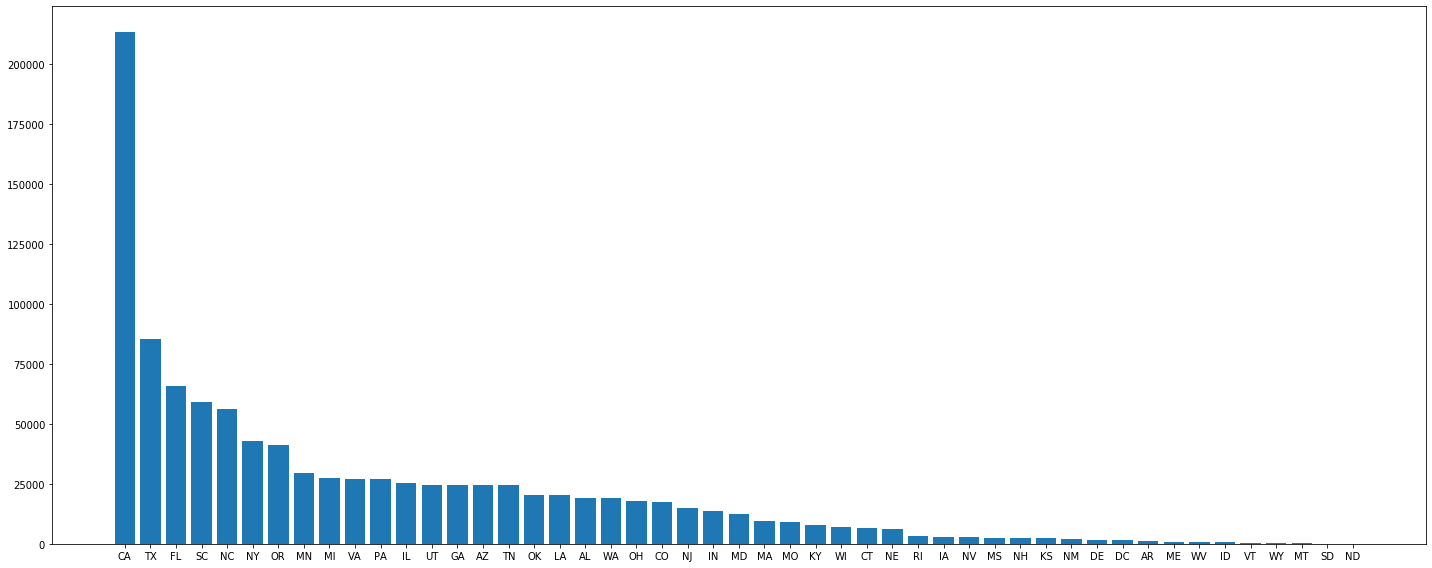

In [17]:
plt.figure(figsize=(20,8))
_=plt.bar(accident_state_year["State"],accident_state_year["Accident Count"])
plt.tight_layout()

#This shows that Califronia 

In [18]:
states=[]
states.extend(list(accident_state_year.groupby("State")["Accident Count"].sum().nlargest(3).index.values))

states.extend(list(accident_state_year.groupby("State")["Accident Count"].sum().nsmallest(3).index.values))

states.append('NY')
print(states)

['CA', 'TX', 'FL', 'ND', 'SD', 'WY', 'NY']


In [19]:
accident_state_year_2017=accident_state_year[(accident_state_year["State"].isin(states)) & (accident_state_year["Year"]==2017)]
accident_state_year_2017


,State,Year,Accident Count
2,CA,2017,152664
3,TX,2017,85542
7,FL,2017,60669
16,NY,2017,36878
139,WY,2017,112
145,SD,2017,12
146,ND,2017,4


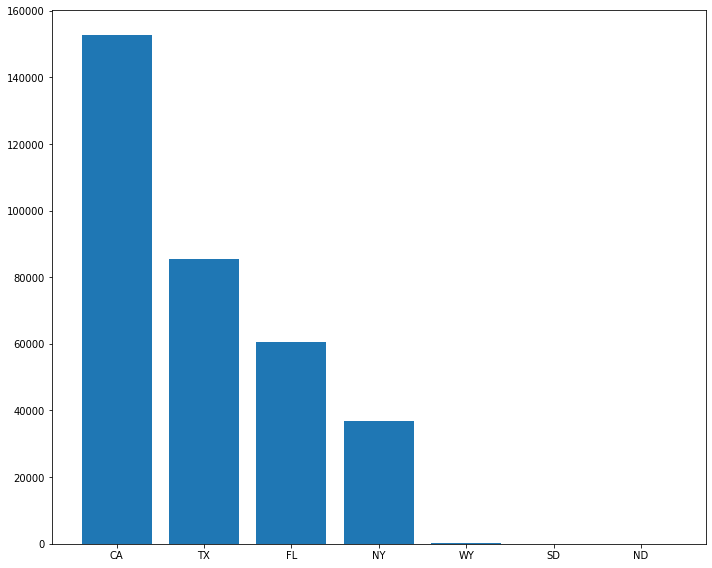

In [20]:
plt.figure(figsize=(10,8))
_=plt.bar(accident_state_year_2017["State"],accident_state_year_2017["Accident Count"])
plt.tight_layout()

In [21]:
# Extract years of interest and get number of accidents for each year
target_years = accident_target[(accident_target["Start_Year"] >= 2017) & (accident_target["Start_Year"] < 2020)]
yearly_accidents = target_years.groupby("Start_Year")
yearly_counts = yearly_accidents["Start_Year"].count()
yearly_counts

Start_Year
2017    717483
2018    892615
2019    953630
Name: Start_Year, dtype: int64

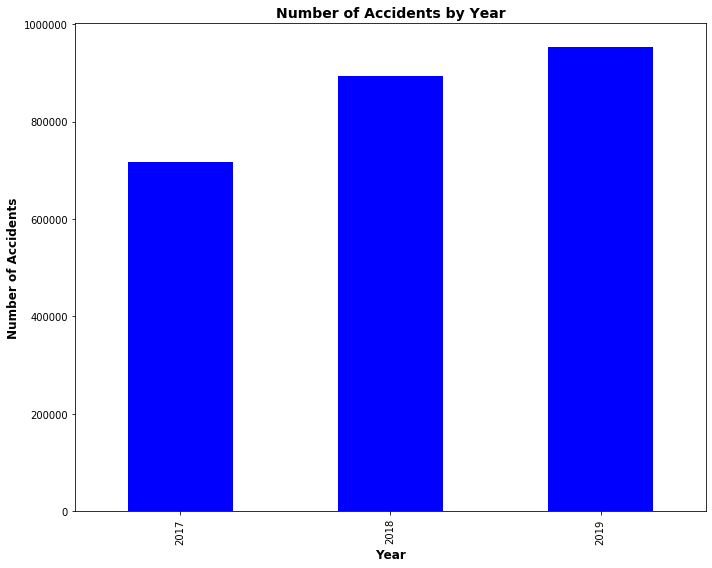

In [43]:
# Plot the number of accidents by year
accident_count = yearly_counts.plot(kind="bar", color="blue", figsize=(10,8))
plt.title("Number of Accidents by Year", fontweight="bold", fontsize=14)
plt.xlabel("Year", fontweight='bold', fontsize=12)
plt.ylabel("Number of Accidents", fontweight='bold', fontsize=12)

# Save image and show graph
plt.savefig("Images/AccidentsByYear.png")
plt.tight_layout()
plt.show();

In [24]:
# Get severity counts by year
severity_counts = yearly_accidents["Severity"].value_counts()
severity_counts = severity_counts.to_frame()
severity_by_year = severity_counts.rename(columns= {severity_counts.columns[0]: "Severity Count"})
severity_by_year.reset_index(inplace=True)
severity_by_year

,Start_Year,Severity,Severity Count
0,2017,2,461971
1,2017,3,231081
2,2017,4,24149
3,2017,1,282
4,2018,2,574016
5,2018,3,292570
6,2018,4,25770
7,2018,1,259
8,2019,2,687573
9,2019,3,237790


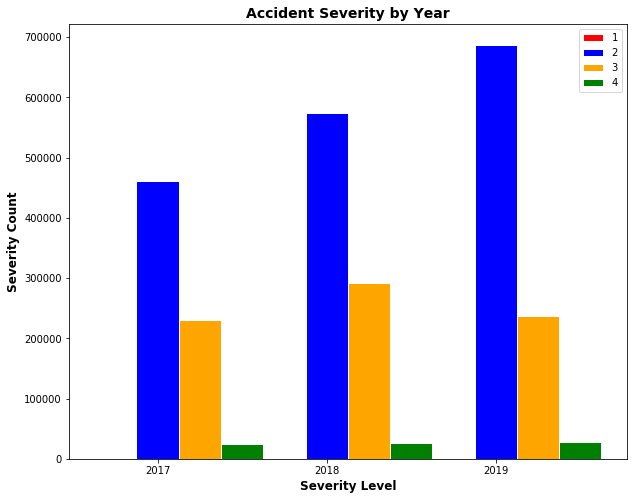

In [46]:
# Create plot to compare accident severity levels by year
plt.figure(figsize=(10, 8))
barWidth = 0.25

# Set height of bar
y1 = severity_by_year[severity_by_year["Severity"]==1]["Severity Count"].to_list()
y2 = severity_by_year[severity_by_year["Severity"]==2]["Severity Count"].to_list()
y3 = severity_by_year[severity_by_year["Severity"]==3]["Severity Count"].to_list()
y4 = severity_by_year[severity_by_year["Severity"]==4]["Severity Count"].to_list()

# Set position of bar on X axis
x1 = np.arange(len(y1))
x2 = [x + barWidth for x in x1]
x3 = [x + barWidth for x in x2]
x4 = [x + barWidth for x in x3]
 
# Make the plot
plt.bar(x1, bars1, color="r", width=barWidth, edgecolor="white", label="1")
plt.bar(x2, bars2, color="b", width=barWidth, edgecolor="white", label="2")
plt.bar(x3, bars3, color="orange", width=barWidth, edgecolor="white", label="3")
plt.bar(x4, bars4, color="g", width=barWidth, edgecolor="white", label="4")
 
# Add xticks and lables
plt.title("Accident Severity by Year", fontweight="bold", fontsize=14)
plt.xlabel("Severity Level", fontweight="bold", fontsize=12)
plt.ylabel("Severity Count", fontweight="bold", fontsize=12)
plt.xticks([r + barWidth for r in range(len(y1))], ["2017", "2018", "2019"])
 
# Create legend, save image and show graph
plt.legend()
plt.savefig("Images/SeverityByYear.png")
plt.show();


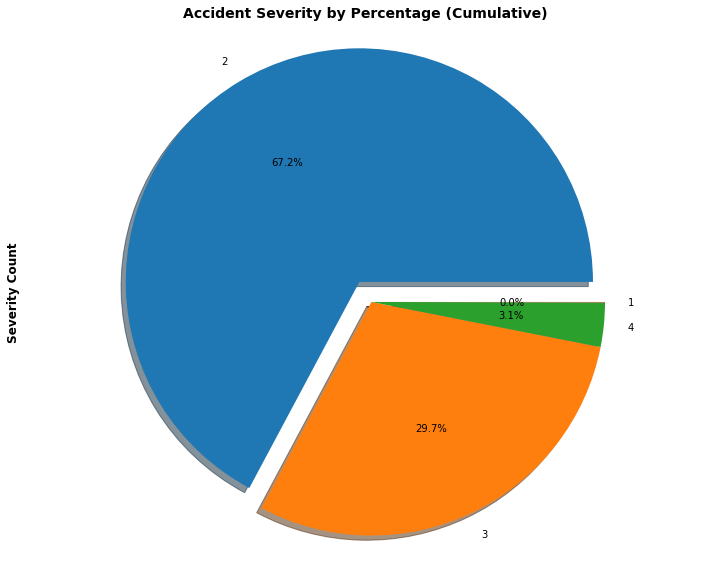

In [45]:
# Create a pie chart to showcase the percentage of each severity 
plt.figure(figsize=(10, 8))
accident_target["Severity"].value_counts().plot.pie(explode=[0.1,0,0,0],autopct="%1.1f%%",shadow=True)
plt.title("Accident Severity by Percentage (Cumulative)", fontweight="bold", fontsize=14)
plt.ylabel("Severity Count",fontweight="bold", fontsize=12)
plt.axis("equal")

# Save image and show graph
plt.savefig("Images/TotalSeverity.png")
plt.tight_layout()
plt.show()